### Ultralytics model Evaluator
Here I would calc the metrics and function for evaluating the Ultralytics models.

In [1]:
image_path = "/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2157/IMG_2157_p4.png"
annotation_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split/labels/IMG_2157_p4.txt'
img_size = 512

In [29]:
from ultralytics import YOLO

yolov8_checkpoint = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train16/weights/best.pt"
predictor = YOLO(yolov8_checkpoint)
outputs = predictor(image_path, imgsz=512, verbose=False, conf=0.3)

In [30]:
from src.segmentation.evaluation.ultralytics_evaluator import UltralyticsEvaluator
evaluator = UltralyticsEvaluator(num_classes=3, image_size=512)

In [31]:
gt_boxes = evaluator.parse_annotations(file_path=annotation_path)
pred_boxes = evaluator.parse_model_outputs(outputs)

In [32]:
# count the clear ground truth boxes
len([box for box in gt_boxes if box['class_id'] == 1])

17

Ground truth boxes:


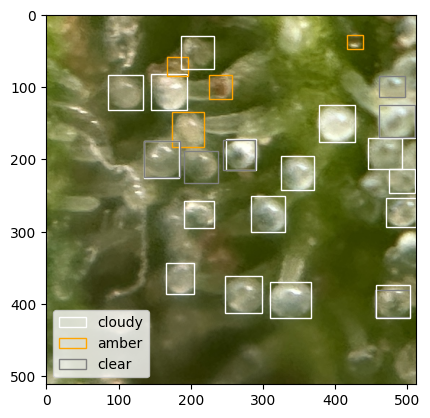

Predicted boxes:


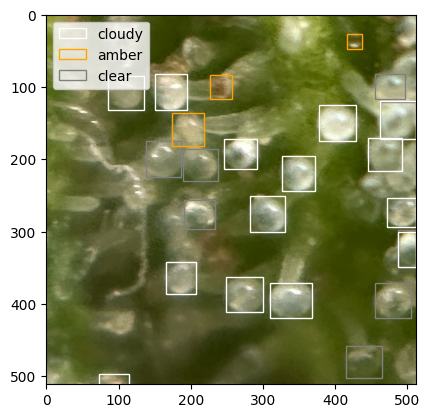

In [33]:
# plot the ground truth and predicted boxes
print("Ground truth boxes:")
evaluator.plot_boxes(image_path, gt_boxes, is_ground_truth=False)
print("Predicted boxes:")
evaluator.plot_boxes(image_path, pred_boxes, is_ground_truth=False)

In [35]:
eval_results = evaluator.evaluate_patch(gt_boxes, pred_boxes, single_class=True, iou_thresh=0.5)
eval_results

{'metrics': {'precision': 0.8, 'recall': 0.7407407407407407},
 'confusion_matrix': array([[20,  7],
        [ 5,  0]]),
 'normalized_confusion_matrix': array([[    0.74074,     0.25926],
        [          1,           0]], dtype=float32)}

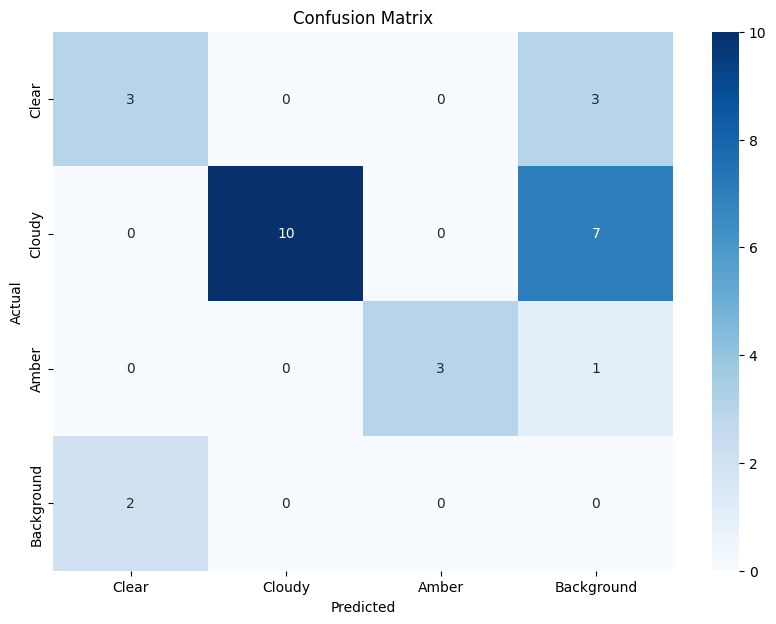

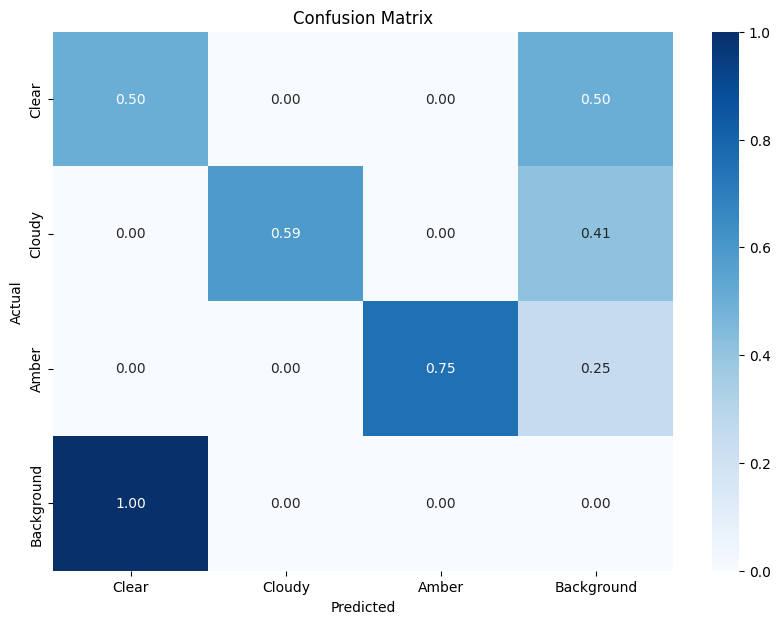

In [9]:
evaluator.plot_confusion_matrix(eval_results["confusion_matrix"])
evaluator.plot_confusion_matrix(eval_results['normalized_confusion_matrix'])

### Background Class in Confusion Matrix

1.  **False Positives (FP)**: These occur when the model predicts an object where there is none in the ground truth. In the confusion matrix, this is represented in the last row corresponding to the background (usually `-1` or `num_classes`).
    
2.  **False Negatives (FN)**: These occur when an actual object (ground truth) is not detected by the model. In the confusion matrix, this is represented in the last column corresponding to the background.

### Mock Examples

In [10]:
# Example data
gt_boxes = [
    {'bbox': [100, 100, 150, 150], 'class_id': 0},
    {'bbox': [200, 200, 250, 250], 'class_id': 1},
    {'bbox': [300, 300, 350, 350], 'class_id': 2}
]

pred_boxes = [
    {'bbox': [105, 105, 155, 155], 'class_id': 0, 'score': 0.9},
    {'bbox': [205, 205, 255, 255], 'class_id': 1, 'score': 0.85},
    {'bbox': [400, 400, 450, 450], 'class_id': 2, 'score': 0.8}
]

# Evaluate
results = evaluator.evaluate_patch(gt_boxes, pred_boxes, iou_thresh=0.5)

# Output
print("Metrics:", results["metrics"])
print("Confusion Matrix:\n", results["confusion_matrix"])
print(f"Normalized Confusion Matrix:\n{results['normalized_confusion_matrix']}")


Metrics: {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'class_wise_precision': array([          1,           1,           0]), 'class_wise_recall': array([          1,           1,           0])}
Confusion Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
Normalized Confusion Matrix:
[[          1           0           0           0]
 [          0           1           0           0]
 [          0           0           0           1]
 [          0           0           1           0]]


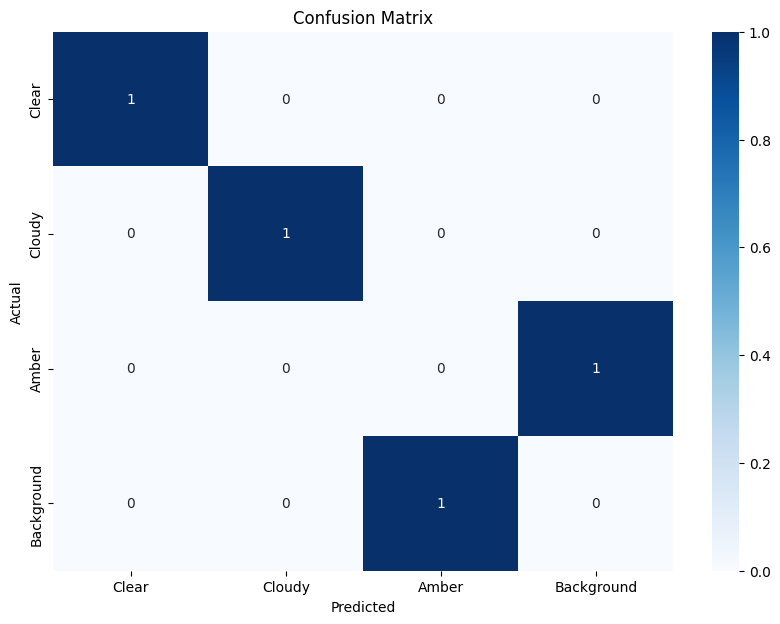

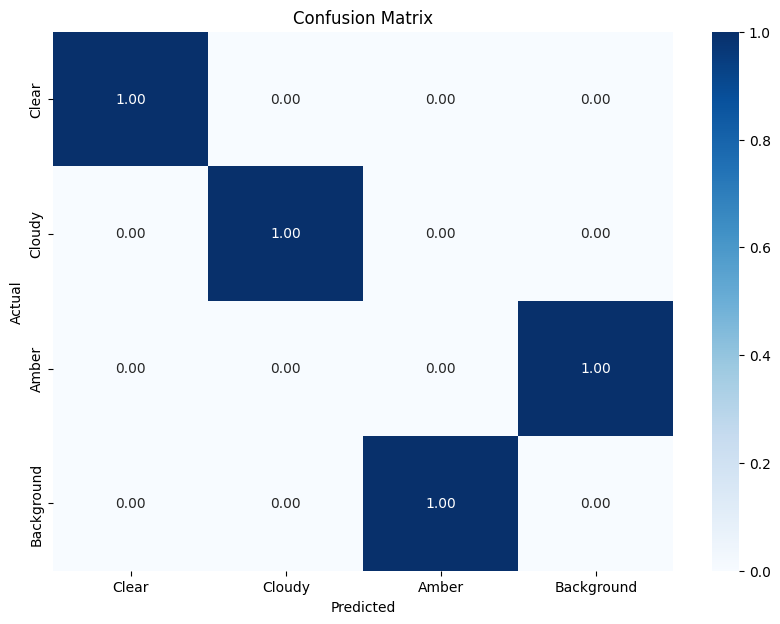

In [11]:
evaluator.plot_confusion_matrix(results["confusion_matrix"])
evaluator.plot_confusion_matrix(results['normalized_confusion_matrix'])

In [12]:
# Example data
gt_boxes = [
    {'bbox': [100, 100, 150, 150], 'class_id': 0},  # Clear
    {'bbox': [200, 200, 250, 250], 'class_id': 1},  # Cloudy
    {'bbox': [300, 300, 350, 350], 'class_id': 2},  # Amber
    {'bbox': [400, 400, 450, 450], 'class_id': 0},  # Clear
    {'bbox': [500, 500, 550, 550], 'class_id': 1}   # Cloudy
]

pred_boxes = [
    {'bbox': [105, 105, 155, 155], 'class_id': 0, 'score': 0.9},  # Clear
    {'bbox': [205, 205, 255, 255], 'class_id': 1, 'score': 0.85},  # Cloudy
    {'bbox': [400, 400, 450, 450], 'class_id': 2, 'score': 0.8},   # Amber
    {'bbox': [405, 405, 455, 455], 'class_id': 0, 'score': 0.7},   # Clear
    {'bbox': [100, 100, 150, 150], 'class_id': 1, 'score': 0.75}   # Cloudy
]

# Evaluate
results = evaluator.evaluate_patch(gt_boxes, pred_boxes, iou_thresh=0.5)

# Output
print("Metrics:", results["metrics"])
print("Confusion Matrix:\n", results["confusion_matrix"])
print(f"Normalized Confusion Matrix:\n{results['normalized_confusion_matrix']}")

Metrics: {'precision': 0.6, 'recall': 0.6, 'class_wise_precision': array([          1,         0.5,           0]), 'class_wise_recall': array([          1,         0.5,           0])}
Confusion Matrix:
 [[2 0 0 0]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 1 0]]
Normalized Confusion Matrix:
[[          1           0           0           0]
 [          0         0.5           0         0.5]
 [          0           0           0           1]
 [          0         0.5         0.5           0]]


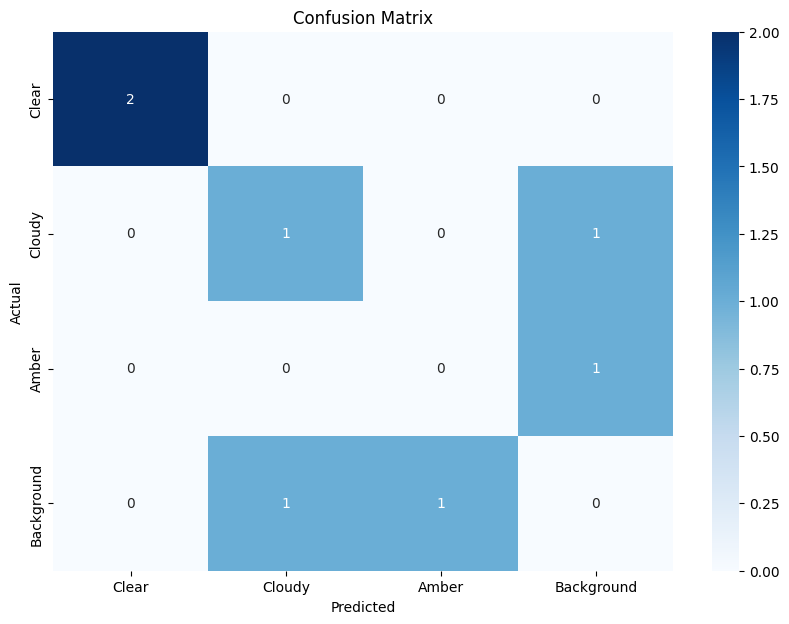

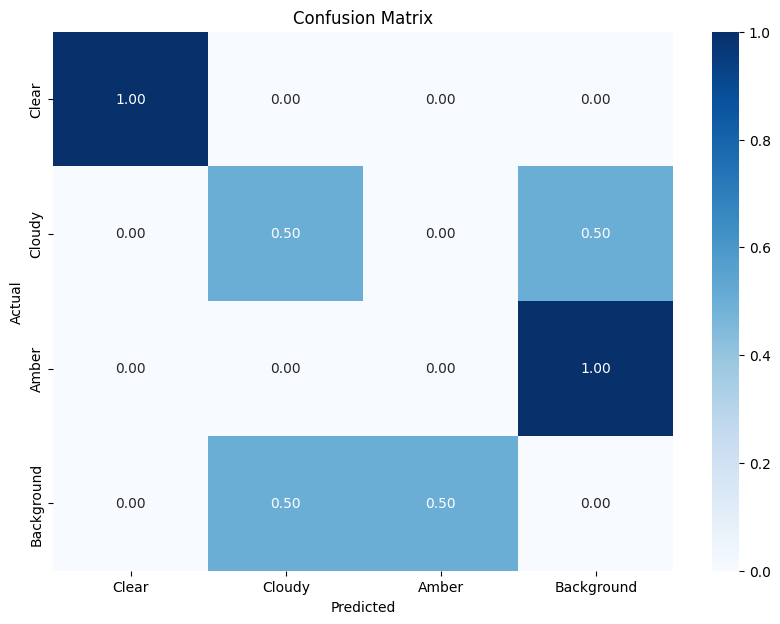

In [13]:
evaluator.plot_confusion_matrix(results["confusion_matrix"])
evaluator.plot_confusion_matrix(results['normalized_confusion_matrix'])

### Detectron2 Models Evaluator

In [1]:
detectron2_model_config = {
        "model_name": "mask_rcnn_R_50_FPN_3x",
        "checkpoint": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/model_final.pth",
        "yaml_file": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/config.yaml"
    }

In [2]:
image_path = "/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2157/IMG_2157_p4.png"
coco_annotations_file = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json"
img_size = 512

In [3]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()
# load config
cfg.merge_from_file(detectron2_model_config['yaml_file'])

# load checkpoint
cfg.MODEL.WEIGHTS = detectron2_model_config['checkpoint']
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# define predictor
predictor = DefaultPredictor(cfg)

Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [4]:
from src.segmentation.evaluation.detectron2_evaluator import Detectron2Evaluator

det_evaluator = Detectron2Evaluator(num_classes=3, coco_annotations_file_path=coco_annotations_file)

In [5]:
dt_gt_boxes = det_evaluator.parse_annotations(file_path="IMG_2157_p4.png")

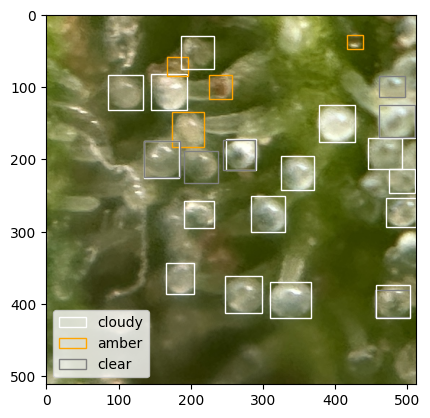

In [6]:
det_evaluator.plot_boxes(image_path, dt_gt_boxes, is_ground_truth=False)

In [7]:
import cv2
outputs = predictor(cv2.imread(image_path))

/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
dt_pred_boxes = det_evaluator.parse_model_outputs(outputs)

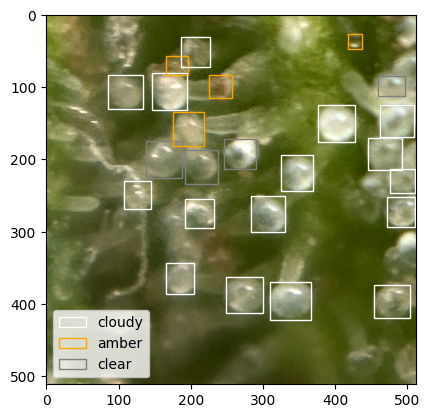

In [9]:
det_evaluator.plot_boxes(image_path, dt_pred_boxes, is_ground_truth=False)

In [10]:
dt_eval_results = det_evaluator.evaluate_patch(dt_gt_boxes, dt_pred_boxes, iou_thresh=0.5, single_class=False)

CM after matches: [[ 5  0  0  0]
 [ 0 15  0  0]
 [ 0  0  4  0]
 [ 0  0  0  0]]
CM after FPs: [[ 5  0  0  0]
 [ 0 15  0  0]
 [ 0  0  4  0]
 [ 0  1  0  0]]
CM after FNs: [[ 5  0  0  1]
 [ 0 15  0  2]
 [ 0  0  4  0]
 [ 0  1  0  0]]
CM after matches: [[ 5  0  0  0]
 [ 0 15  0  0]
 [ 0  0  4  0]
 [ 0  0  0  0]]
CM after FPs: [[ 5  0  0  0]
 [ 0 15  0  0]
 [ 0  0  4  0]
 [ 0  1  0  0]]
CM after FNs: [[ 5  0  0  1]
 [ 0 15  0  2]
 [ 0  0  4  0]
 [ 0  1  0  0]]


In [11]:
dt_eval_results

{'metrics': {'precision': 0.96,
  'recall': 0.8888888888888888,
  'class_wise_precision': array([1.    , 0.9375, 1.    ]),
  'class_wise_recall': array([0.83333333, 0.88235294, 1.        ])},
 'confusion_matrix': array([[ 5,  0,  0,  1],
        [ 0, 15,  0,  2],
        [ 0,  0,  4,  0],
        [ 0,  1,  0,  0]]),
 'normalized_confusion_matrix': array([[0.8333333 , 0.        , 0.        , 0.16666667],
        [0.        , 0.88235295, 0.        , 0.11764706],
        [0.        , 0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ]], dtype=float32)}

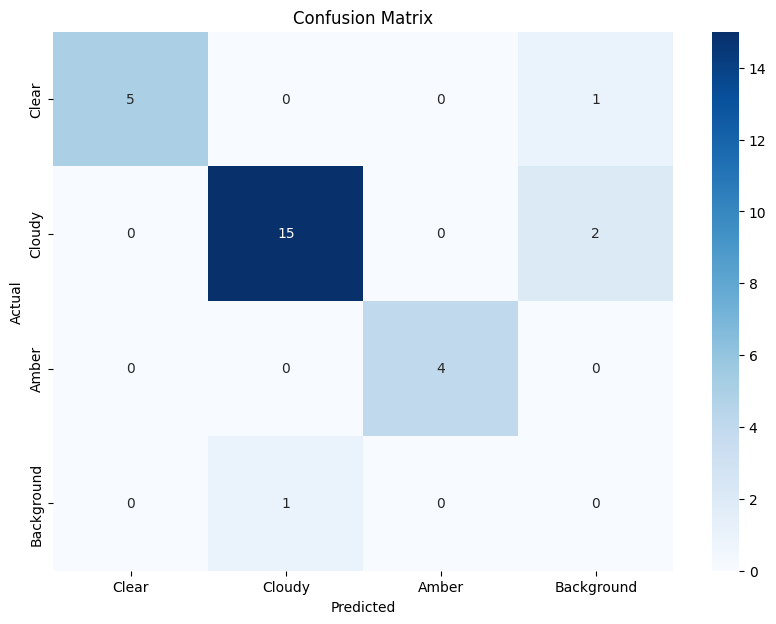

In [12]:
det_evaluator.plot_confusion_matrix(dt_eval_results["confusion_matrix"])

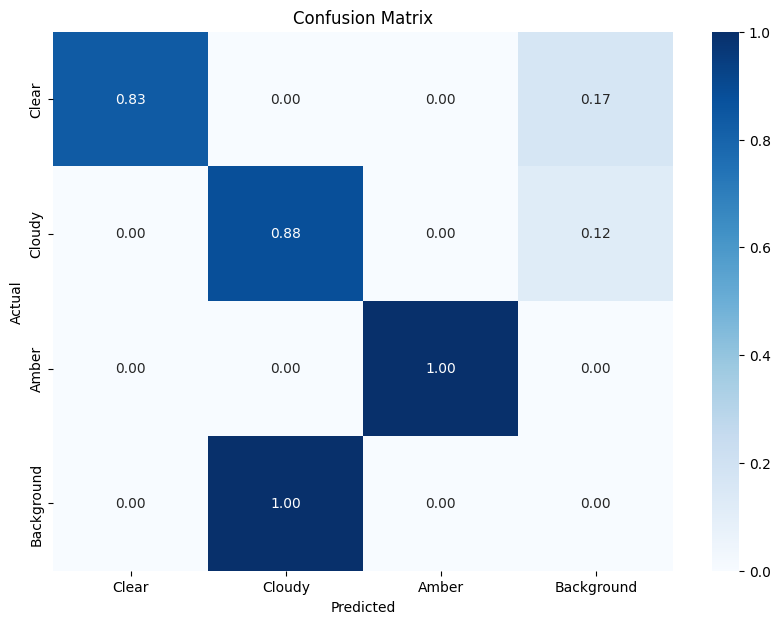

In [13]:
det_evaluator.plot_confusion_matrix(dt_eval_results["normalized_confusion_matrix"])

In [14]:
# get annotations for a single image
patches_gt_boxes = det_evaluator.get_annotations_for_image_patches(image_base_name="IMG_2157")
patches_gt_boxes

{'IMG_2157_p10.png': [{'bbox': [365, 412, 400, 450], 'class_id': 2},
  {'bbox': [438, 210, 471, 243], 'class_id': 2},
  {'bbox': [381, 261, 407, 288], 'class_id': 2},
  {'bbox': [313, 369, 351, 403], 'class_id': 2},
  {'bbox': [341, 321, 387, 367], 'class_id': 2}],
 'IMG_2157_p1.png': [{'bbox': [230, 272, 273, 317], 'class_id': 1},
  {'bbox': [244, 354, 284, 399], 'class_id': 1},
  {'bbox': [165, 416, 213, 456], 'class_id': 1},
  {'bbox': [112, 419, 145, 454], 'class_id': 1},
  {'bbox': [112, 371, 152, 416], 'class_id': 1},
  {'bbox': [209, 65, 239, 101], 'class_id': 1},
  {'bbox': [464, 369, 511, 425], 'class_id': 1},
  {'bbox': [119, 276, 159, 319], 'class_id': 1},
  {'bbox': [133, 475, 162, 502], 'class_id': 2},
  {'bbox': [194, 291, 231, 331], 'class_id': 1},
  {'bbox': [185, 389, 227, 424], 'class_id': 2},
  {'bbox': [157, 298, 195, 327], 'class_id': 1},
  {'bbox': [165, 227, 216, 273], 'class_id': 1},
  {'bbox': [172, 324, 212, 359], 'class_id': 1}],
 'IMG_2157_p2.png': [{'bbox':

In [15]:
images_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/v0.1"
patches_pred_boxes = det_evaluator.predict_and_parse_image_patches("IMG_2157", images_path, predictor)

Processing patch: IMG_2157_p7.png
Processing patch: IMG_2157_p8.png
Processing patch: IMG_2157_p6.png
Processing patch: IMG_2157_p3.png
Processing patch: IMG_2157_p1.png
Processing patch: IMG_2157_p4.png
Processing patch: IMG_2157_p10.png
Processing patch: IMG_2157_p2.png
Processing patch: IMG_2157_p5.png
Processing patch: IMG_2157_p9.png
Processing patch: IMG_2157_p0.png


In [19]:
patches_pred_boxes

{'IMG_2157_p7.png': [{'bbox': [358.6096, 54.087646, 403.467, 100.61629],
   'score': 0.9997718,
   'class_id': 1},
  {'bbox': [430.49847, 0.687879, 455.2712, 16.616299],
   'score': 0.983591,
   'class_id': 2}],
 'IMG_2157_p8.png': [{'bbox': [311.4877, 58.2126, 369.9477, 107.22697],
   'score': 0.99967337,
   'class_id': 1},
  {'bbox': [0.9416162, 73.529205, 43.632786, 129.6768],
   'score': 0.99914265,
   'class_id': 1},
  {'bbox': [436.13098, 84.80762, 478.93472, 126.78611],
   'score': 0.99904233,
   'class_id': 2},
  {'bbox': [44.13821, 19.425573, 87.66807, 65.380875],
   'score': 0.9986755,
   'class_id': 0},
  {'bbox': [322.53894, 101.642654, 367.8266, 137.09523],
   'score': 0.9983992,
   'class_id': 1},
  {'bbox': [183.35605, 216.36792, 239.29237, 269.46436],
   'score': 0.9961545,
   'class_id': 1},
  {'bbox': [320.76093, 103.63271, 368.01593, 113.61398],
   'score': 0.5020683,
   'class_id': 1}],
 'IMG_2157_p6.png': [{'bbox': [442.43378, 217.74905, 469.46768, 240.72258],
   '

In [20]:
result = det_evaluator.evaluate_image(patches_gt_boxes_dict=patches_gt_boxes, patches_pred_boxes_dict=patches_pred_boxes, iou_thresh=0.5)

CM after matches: [[ 0  0  0  0]
 [ 3 28 20  0]
 [ 4 40 18  0]
 [ 0  0  0  0]]
CM after FPs: [[ 0  0  0  0]
 [ 3 28 20  0]
 [ 4 40 18  0]
 [ 0  3  0  0]]
CM after FNs: [[ 0  0  0  1]
 [ 3 28 20  3]
 [ 4 40 18  1]
 [ 0  3  0  0]]
CM after matches: [[ 0  0  0  0]
 [ 3 28 20  0]
 [ 4 40 18  0]
 [ 0  0  0  0]]
CM after FPs: [[ 0  0  0  0]
 [ 3 28 20  0]
 [ 4 40 18  0]
 [ 0  3  0  0]]
CM after FNs: [[ 0  0  0  1]
 [ 3 28 20  3]
 [ 4 40 18  1]
 [ 0  3  0  0]]


In [17]:
result

{'metrics': {'precision': 0.9387755102040817,
  'recall': 0.9019607843137255,
  'class_wise_precision': array([0.        , 0.90322581, 1.        ]),
  'class_wise_recall': array([0.        , 0.90322581, 0.94736842])},
 'confusion_matrix': array([[ 0,  0,  0,  1],
        [ 3, 28, 20,  3],
        [ 4, 40, 18,  1],
        [ 0,  3,  0,  0]]),
 'normalized_confusion_matrix': array([[0.        , 0.        , 0.        , 1.        ],
        [0.05555556, 0.5185185 , 0.37037036, 0.05555556],
        [0.06349207, 0.63492066, 0.2857143 , 0.01587302],
        [0.        , 1.        , 0.        , 0.        ]], dtype=float32)}

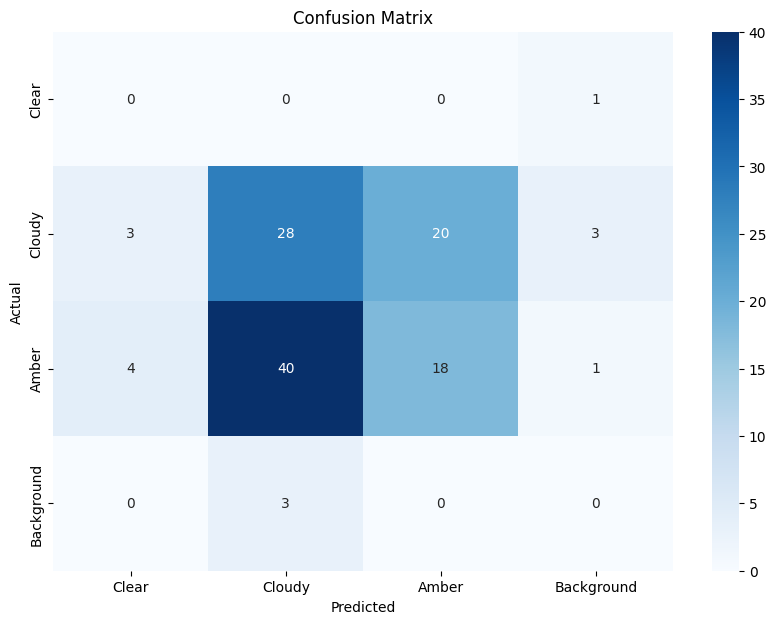

In [18]:
det_evaluator.plot_confusion_matrix(result["confusion_matrix"])